In [1]:
import torch
import torch.nn as nn

from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils
import torch.utils.data as Data

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

batch_size = 5

train_data = dsets.ImageFolder('./squir_chip_data/train/', train_transform)
test_data = dsets.ImageFolder('./squir_chip_data/val/', test_transform)

train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

In [9]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (7, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

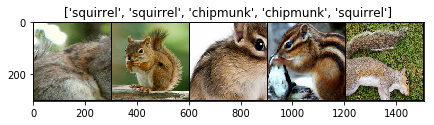

In [10]:
images, labels = iter(train_loader).next()

imshow(torchvision.utils.make_grid(images, normalize=True), [train_data.classes[i] for i in labels])

# Define Model

In [13]:
model = models.inception_v3(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /Users/donghochoi/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:06, 17179570.56it/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [14]:
model.aux_logits = False

fine_tune = False

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

In [15]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [17]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)

# Train Model

In [18]:
num_epochs = 30

In [19]:
for epoch in range(num_epochs):
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % 5 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, cost.item()))

Epoch [1/30], lter [5/28] Loss: 0.4229
Epoch [1/30], lter [10/28] Loss: 1.6802
Epoch [1/30], lter [15/28] Loss: 0.5281
Epoch [1/30], lter [20/28] Loss: 1.2116
Epoch [1/30], lter [25/28] Loss: 0.9874
Epoch [2/30], lter [5/28] Loss: 0.3348
Epoch [2/30], lter [10/28] Loss: 1.0830
Epoch [2/30], lter [15/28] Loss: 1.3631
Epoch [2/30], lter [20/28] Loss: 0.5012
Epoch [2/30], lter [25/28] Loss: 0.4966
Epoch [3/30], lter [5/28] Loss: 0.3431
Epoch [3/30], lter [10/28] Loss: 1.3824
Epoch [3/30], lter [15/28] Loss: 0.2853
Epoch [3/30], lter [20/28] Loss: 0.4546
Epoch [3/30], lter [25/28] Loss: 0.4231
Epoch [4/30], lter [5/28] Loss: 0.4504
Epoch [4/30], lter [10/28] Loss: 0.4822
Epoch [4/30], lter [15/28] Loss: 0.4415
Epoch [4/30], lter [20/28] Loss: 0.3197
Epoch [4/30], lter [25/28] Loss: 0.2064
Epoch [5/30], lter [5/28] Loss: 0.9452
Epoch [5/30], lter [10/28] Loss: 0.2305
Epoch [5/30], lter [15/28] Loss: 0.2933
Epoch [5/30], lter [20/28] Loss: 0.6723
Epoch [5/30], lter [25/28] Loss: 0.2237
Epoch

In [22]:
# model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (labels == predicted).sum()
    
print('Accuracy: %f %%' % (100 * float(correct) / 100))

Accuracy: 46.000000 %


In [23]:
classes = ['Squirrel', 'Chipmunk']

Predicted:  Chipmunk Squirrel Squirrel Squirrel Chipmunk


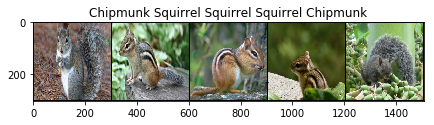

In [24]:
images, labels = iter(test_loader).next()
outputs = model(images)

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))
title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)